# Problem Statement

As the machine learning engineer at a leading edtech company, we have given a dataset of a triplet of question, reference answers and student answers. We also have labels indicating if a corresponding student answer is correct or not. 
Now the task is, given a new student answer to a known question we have to classify it as correct or incorrect.

In [95]:
import xml.etree.ElementTree as ET 
import os
import pandas as pd
import random
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Set working directory path
os.chdir('.\Dataset\Task A')

# Data Reading 

In [3]:
#Read all file names in a directory
xml_files = os.listdir()
xml_files.remove('datanotes.html')

In [4]:
#Parsing xml files
module=[]
questions = []
reference_answer=[]
student_answer={}
question_id=[]
for i, file in enumerate(xml_files):
    tree = ET.parse(file)
    root = tree.getroot()
    question_id.append(root.get('id'))
    module.append(root.get('module'))
    for chld in root:
        if chld.tag=='questionText':
            questions.append(chld.text)
        elif chld.tag=='referenceAnswers':
            for attr in chld:
                reference_answer.append(attr.text)
        elif chld.tag=='studentAnswers':
            for attr in chld:
                student_answer[i]= student_answer.get(i,[])+[(attr.text, attr.get('accuracy'))]

In [25]:
#Checking if each question has same number of student answers
for i in student_answer:
    print(len(student_answer[i]),end=" ")

36 36 36 36 36 36 36 36 35 36 36 35 36 36 36 36 36 36 36 35 36 36 34 35 36 36 36 36 34 35 36 36 36 36 36 36 36 36 36 34 36 32 36 36 36 36 36 36 35 36 36 35 35 36 36 36 38 36 36 38 36 36 39 36 36 36 36 36 36 36 32 36 31 36 36 34 35 36 36 35 36 36 36 33 35 35 35 34 36 34 104 107 49 36 36 35 35 36 35 36 36 36 36 36 36 36 36 35 36 36 36 36 36 36 36 36 34 35 34 36 36 36 36 36 36 37 35 36 36 36 36 36 36 36 36 

In [5]:
def shuffle_data(X,seed=0):
    random.seed(seed)
    return random.sample(X,len(X)) 
    

def get_DataFrame(split=0.15, shuffle=False,seed=0,dataset='complete'):
    '''This function creates dataframe for xml data. Due to the nature of data 
       it will require a custom train test split function. This function accepts arguments
       of split,shuffle, seed and dataset to to create train and test dataframes as well.
       The dataframe will repeate question and reference answers but will have unique 
       student answer.For a single question, the funtion shuffles student answers before
       spliting into train test data.'''  
    
    data_dict={}
    #Creating a Dataframe
    key=0
    for i in range(len(questions)):
        #Calculating start and end points for student answers
        size = int((1-split)*len(student_answer[i]))
        if dataset =='train':
            start = 0
            end = size+1
        elif dataset =='test':
            start = size+1
            end = None
        else:
            start=0
            end= None
        
        #Shuffle student answers for each question      
        if shuffle:
            temp_student_answer = shuffle_data(student_answer[i], seed)
        else:
            temp_student_answer = student_answer[i]
        #Create a Dictionary for each row     
        for j in temp_student_answer[start:end]:
            data_dict[key]=[i, module[i], question_id[i], questions[i], reference_answer[i], j[0], j[1]]
            key +=1
    data_df=pd.DataFrame.from_dict(data_dict, orient='index',
                                   columns=['QuestionNumber','Module','QuestionID','Questions',
                                            'ReferenceAnswer','StudentAnswer','Accuracy'])
    return data_df

# EDA

In [6]:
#Get complete data for EDA
data_df=get_DataFrame()
data_df.head(5)

,QuestionNumber,Module,QuestionID,Questions,ReferenceAnswer,StudentAnswer,Accuracy
0,0,EM,EM_45b,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",By letting it sit in a dish for a day.,incorrect
1,0,EM,EM_45b,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",Let the water evaporate and the salt is left b...,correct
2,0,EM,EM_45b,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",The water evaporated and left salt crystals.,correct
3,0,EM,EM_45b,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",I saw a pinkish grayish color that was blockin...,incorrect
4,0,EM,EM_45b,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",You have to slowly tip the vial for only the w...,incorrect


In [8]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4969 entries, 0 to 4968
Data columns (total 7 columns):
QuestionNumber     4969 non-null int64
Module             4969 non-null object
QuestionID         4969 non-null object
Questions          4969 non-null object
ReferenceAnswer    4969 non-null object
StudentAnswer      4969 non-null object
Accuracy           4969 non-null object
dtypes: int64(1), object(6)
memory usage: 310.6+ KB


Module
ME    23
MX    20
SE    15
EM    12
VB    11
PS    11
LF    11
FN     9
ST     8
MS     7
II     6
LP     2
Name: QuestionNumber, dtype: int64


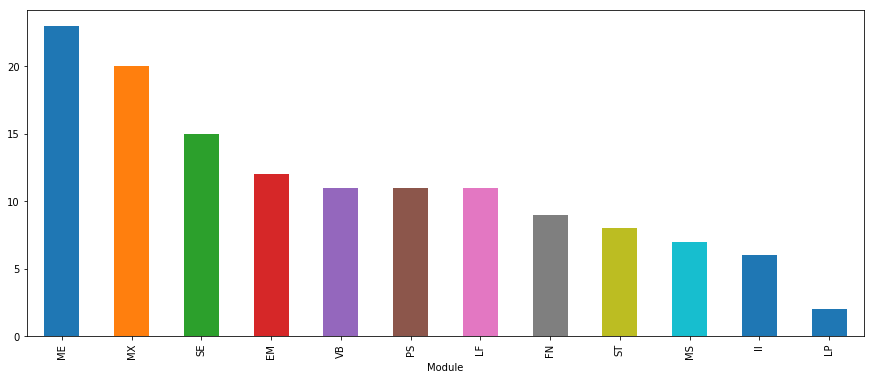

In [17]:
##Checking questions per module
module_freq = data_df.groupby('Module')['QuestionNumber'].nunique().sort_values(ascending=False)
print(module_freq)
module_freq.plot(kind='bar',figsize=(15,6))

Each module has different number of questions, but each question has different number of student answers.

ME    828
MX    697
PS    545
SE    539
EM    430
VB    396
LF    393
FN    323
ST    283
MS    252
II    213
LP     70
Name: Module, dtype: int64


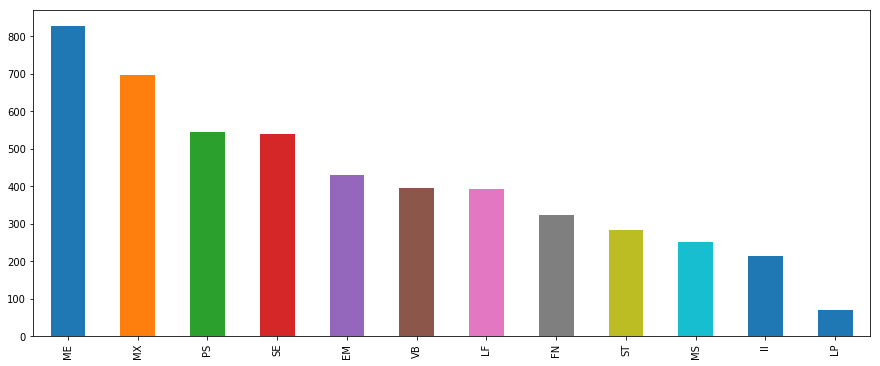

In [18]:
#Student answers per module
print(data_df.Module.value_counts())
data_df.Module.value_counts().sort_values(ascending=False).plot(kind='bar',figsize=(15,6))

incorrect    2961
correct      2008
Name: Accuracy, dtype: int64


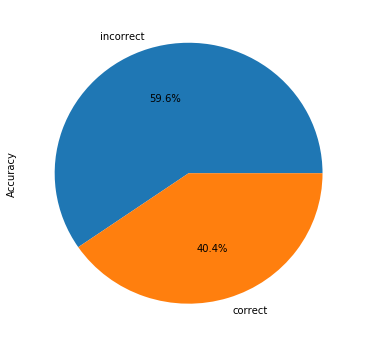

In [21]:
#Target variable distribution
counts = data_df.Accuracy.value_counts()
print(counts)
counts.plot(kind='pie',autopct='%1.1f%%',figsize=(6,6))

We can check if a perticular module is more difficult than others, from the accuracy of student answers. If students are making more mistakes for a perticular module, one of the possibility might be that the module is difficult compared to others.

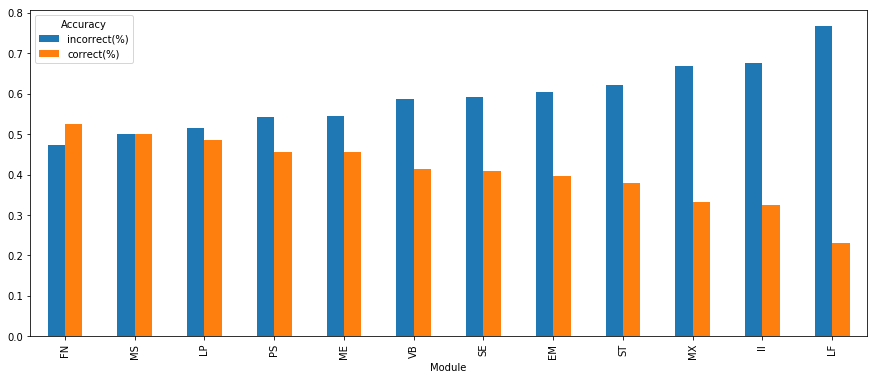

In [26]:
###Checking module difficulty
ans_dist_per_module_df = data_df.groupby('Module')['Accuracy'].value_counts().unstack(level=-1)
ans_dist_per_module_df['correct(%)']=(ans_dist_per_module_df['correct']/(ans_dist_per_module_df['correct']+
                       ans_dist_per_module_df['incorrect']))
ans_dist_per_module_df['incorrect(%)']=(ans_dist_per_module_df['incorrect']/(ans_dist_per_module_df['correct']+
                       ans_dist_per_module_df['incorrect']))
ans_dist_per_module_df[['incorrect(%)','correct(%)']].sort_values(by='correct(%)',
                                   ascending=False).plot(kind='bar',figsize=(15,6))

Similar logic can be used to check questions difficulty

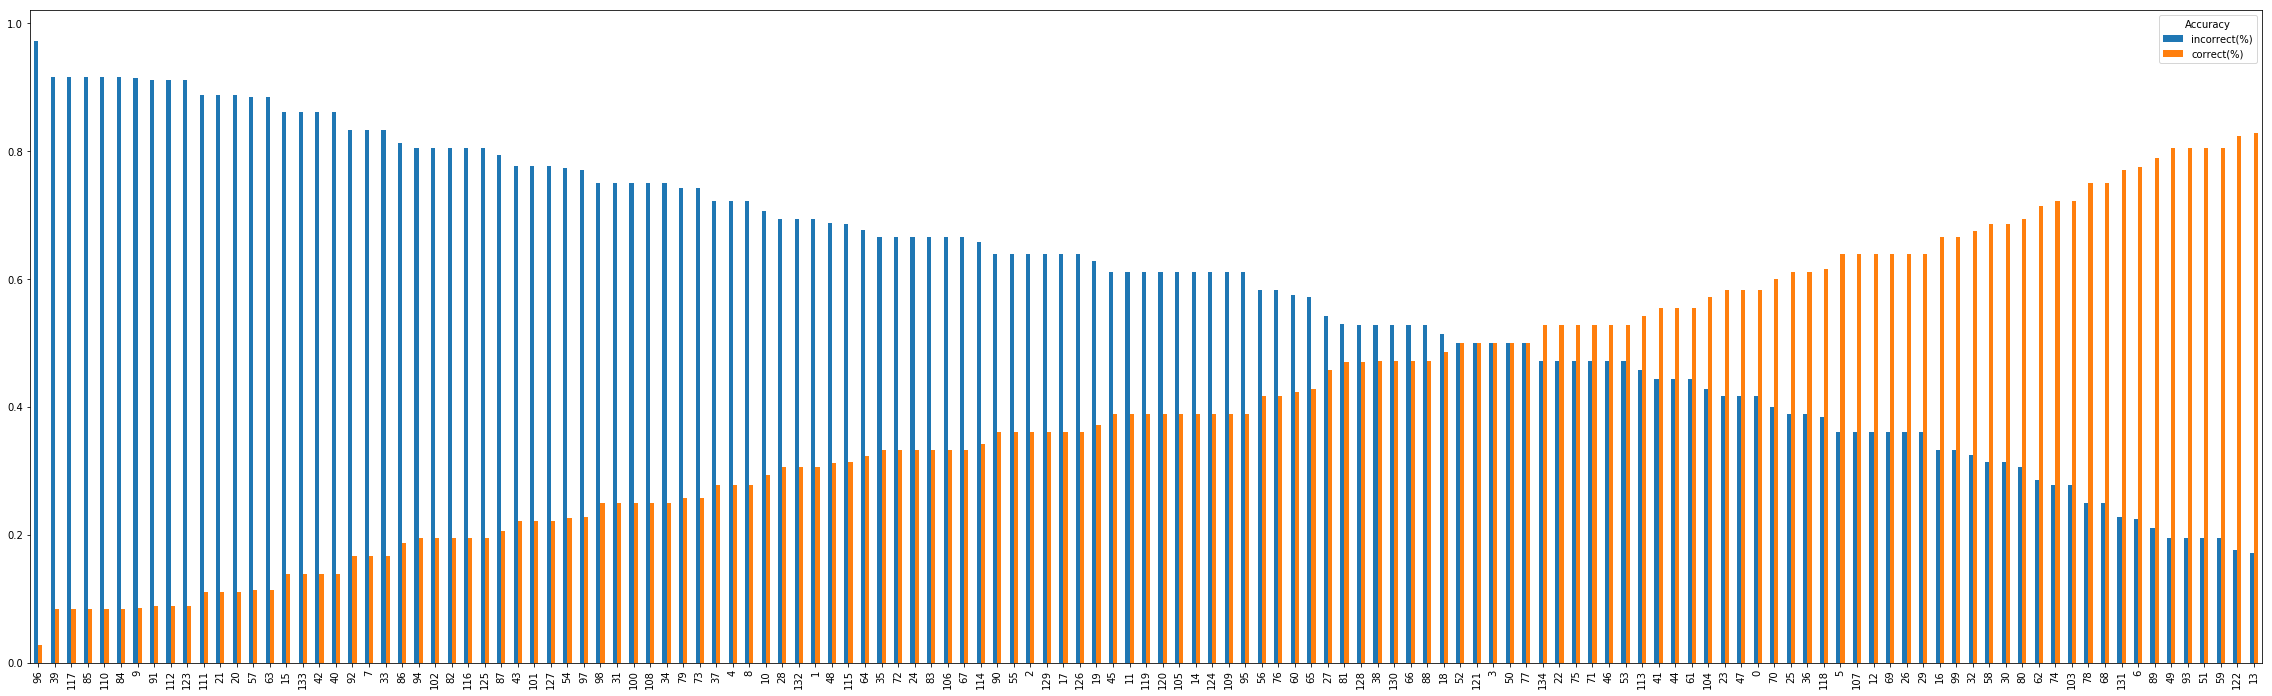

In [31]:
###Checking question difficulty
ans_dist_per_question_df = data_df.groupby('Questions')['Accuracy'].value_counts().unstack(level=-1)
ans_dist_per_question_df['correct(%)']=(ans_dist_per_question_df['correct']/(ans_dist_per_question_df['correct']+
                         ans_dist_per_question_df['incorrect']))
ans_dist_per_question_df['incorrect(%)']=(ans_dist_per_question_df['incorrect']/(ans_dist_per_question_df['correct']+
                         ans_dist_per_question_df['incorrect']))
ans_dist_per_question_df = ans_dist_per_question_df.reset_index()
ans_dist_per_question_df[['incorrect(%)','correct(%)']].sort_values(by='correct(%)',
                                     ascending=True).plot(kind='bar',figsize=(40,12))

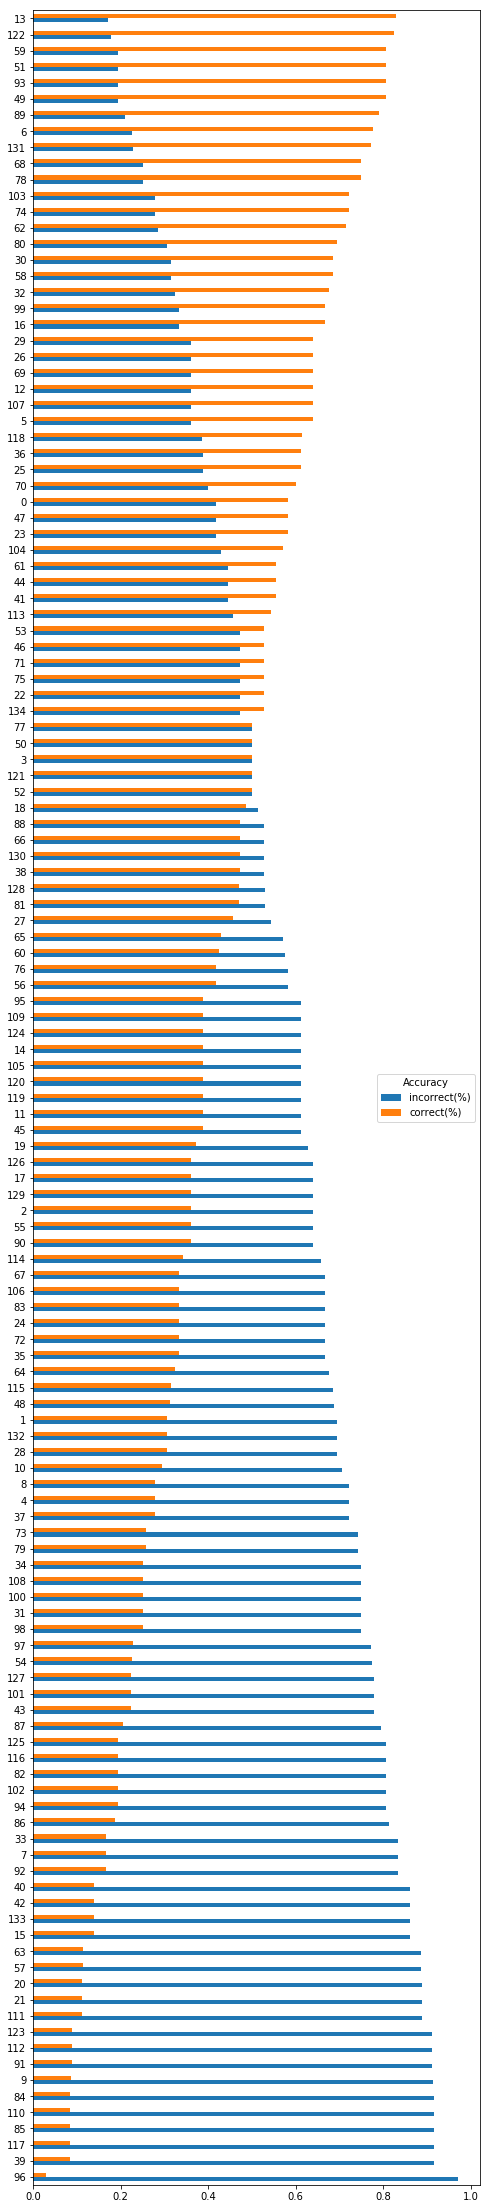

In [33]:
ans_dist_per_question_df[['incorrect(%)','correct(%)']].sort_values(by='correct(%)',
                                     ascending=True).plot(kind='barh',figsize=(8,40))

We can clearly see a pattern in these plots. Question number 96 seems to be a very difficult question

I think we all have heard that, when students don't know the answers they write anything just to fill the space; even if the actual answer is short. That means, it is possible to have a higher word count for incorrect answers. Let's check if the myth is true by taking the ratio of student answer word count to that of a reference answer word count. 

In [34]:
def tokenize(text, isStopWord=False, return_string=False):
    ''' Text cleaning. 
    input:
        text: string to be cleaned
    parameters:
        isStopWord:True to remove stopword while tokenizing(Default:False)
        return_string: True to return tokens in a string instead of separate words
                       (Default:False)
    Return:
        Tokenized words or string'''
    if isStopWord:
        stop = stopwords.words('english') + list(string.punctuation)+['``',"''"]
    else:
        stop = list(string.punctuation)+ ['``',"''"]
    words = [word for word in word_tokenize(text.lower()) if word not in stop]
    if return_string:
        words = ' '.join(word for word in words)  
    return words

def get_words(df, isStopWord=False, return_string=False):
    '''This function accepts dataframe to create word tokens for question,
       referenceAnswer and studentAnswer columns.
     Parameters
        isStopWord: True to remove stopword while tokenizing(Default:False)
        return_string: True to return tokens in a string instead of separate words
                       (Default:False)
     Return:
        Dataframe with word tokens'''
        
    df['Question_words'] = df['Questions'].apply(lambda x: tokenize(x, isStopWord,return_string))
    df['ReferenceAnswer_words']=df['ReferenceAnswer'].apply(lambda x: tokenize(x, isStopWord,return_string))
    df['StudentAnswer_words']=df['StudentAnswer'].apply(lambda x: tokenize(x, isStopWord,return_string))
    return df

In [37]:
#Getting dataframe with words and counts after punctuation
data_df=get_words(data_df)
data_df['ReferenceAnswer_word_count']=data_df['ReferenceAnswer_words'].apply(len)
data_df['StudentAnswer_word_count']=data_df['StudentAnswer_words'].apply(len)
data_df.head(5)

,QuestionNumber,Module,QuestionID,Questions,ReferenceAnswer,StudentAnswer,Accuracy,Question_words,ReferenceAnswer_words,StudentAnswer_words,ReferenceAnswer_word_count,StudentAnswer_word_count
0,0,EM,EM_45b,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",By letting it sit in a dish for a day.,incorrect,"[you, used, several, methods, to, separate, an...","[the, water, was, evaporated, leaving, the, salt]","[by, letting, it, sit, in, a, dish, for, a, day]",7,10
1,0,EM,EM_45b,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",Let the water evaporate and the salt is left b...,correct,"[you, used, several, methods, to, separate, an...","[the, water, was, evaporated, leaving, the, salt]","[let, the, water, evaporate, and, the, salt, i...",7,10
2,0,EM,EM_45b,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",The water evaporated and left salt crystals.,correct,"[you, used, several, methods, to, separate, an...","[the, water, was, evaporated, leaving, the, salt]","[the, water, evaporated, and, left, salt, crys...",7,7
3,0,EM,EM_45b,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",I saw a pinkish grayish color that was blockin...,incorrect,"[you, used, several, methods, to, separate, an...","[the, water, was, evaporated, leaving, the, salt]","[i, saw, a, pinkish, grayish, color, that, was...",7,11
4,0,EM,EM_45b,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",You have to slowly tip the vial for only the w...,incorrect,"[you, used, several, methods, to, separate, an...","[the, water, was, evaporated, leaving, the, salt]","[you, have, to, slowly, tip, the, vial, for, o...",7,13


Since we know the reference answer, we can also check if there is any verbal yes/no question. 

In [38]:
data_df['ReferenceAnswer_word_count'].min()

4

Since minimum word count of reference answer is 4, I think it is safe to say that there are no verbal questions

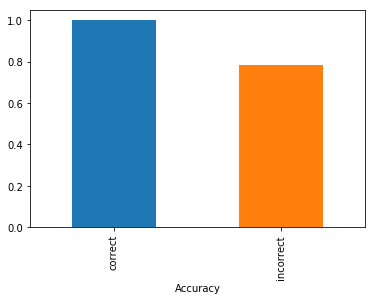

In [40]:
data_df['Student/Reference_word_count']=(data_df['StudentAnswer_word_count']/data_df['ReferenceAnswer_word_count'])
data_df.groupby('Accuracy')['Student/Reference_word_count'].mean().plot(kind='bar')

Correct answers on average has a same word count as reference answer. It was just a myth afterall. Let's check actual distribution. 

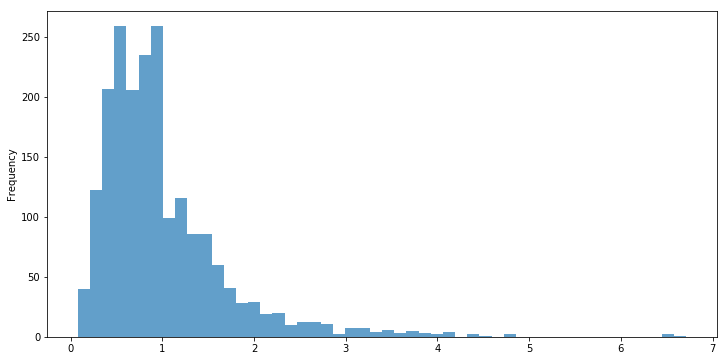

In [44]:
data_df.loc[data_df['Accuracy'] == 'correct','Student/Reference_word_count'].plot(kind='hist',bins=50,alpha=0.7,figsize=(12,6))

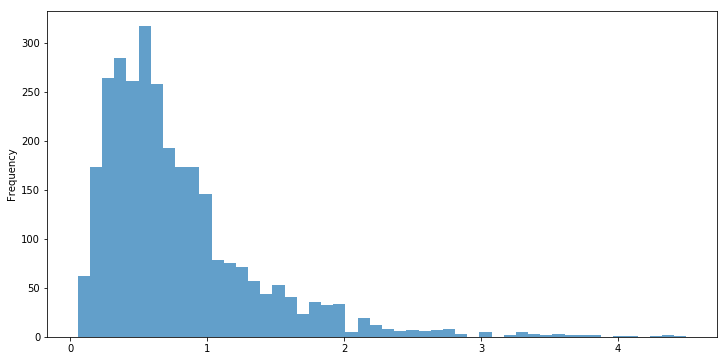

In [45]:
data_df.loc[data_df['Accuracy'] == 'incorrect','Student/Reference_word_count'].plot(kind='hist',bins=50,alpha=0.7,figsize=(12,6))

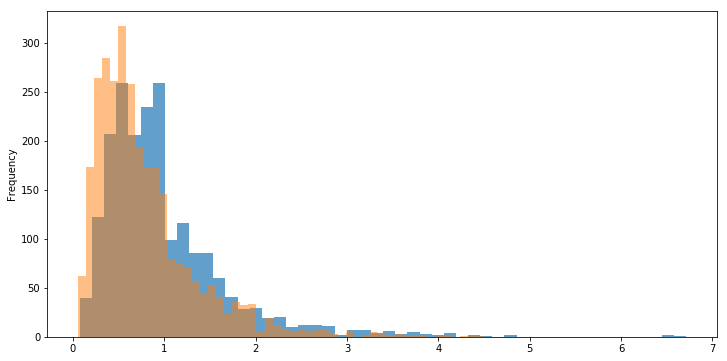

In [46]:
data_df.loc[data_df['Accuracy'] == 'correct','Student/Reference_word_count'].plot(kind='hist',bins=50,alpha=0.7,figsize=(12,6))
data_df.loc[data_df['Accuracy'] == 'incorrect','Student/Reference_word_count'].plot(kind='hist',bins=50,alpha=0.5,figsize=(12,6))

# Model Training

## Simple approach with BoW  

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [92]:
def get_model():
    '''Getting all models to get a baseline performance'''
    models = []
    models.append(('LR' , LogisticRegression(solver='liblinear')))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('NB-Bernoulli', BernoulliNB()))
    models.append(('SGD' , SGDClassifier(max_iter=5, tol=None)))
    models.append(('SVM', SVC(probability=True, gamma='auto')))
    models.append(('GBC', GradientBoostingClassifier()))
    models.append(('RF' , RandomForestClassifier(n_estimators=100)))
    models.append(('MLP', MLPClassifier(max_iter=500)))
    return models

In [62]:
def get_baseline_performanceCV(X,y,models,ngram=(1,1),seed=0):
    '''Getting baseline performance using CountVectorizer with 10-fold cross-validation
       for given models'''
    num_folds=10
    scoring = 'accuracy'
    results = []
    names = []
    for name, model in models:
        pipe_model=Pipeline([('vect', CountVectorizer(ngram_range=ngram)),
                             ('clf', model)])
        kfold = KFold(n_splits=num_folds, random_state=seed)
        cv_results = cross_val_score(pipe_model, X, y, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        print('{}: {:.4} ({:.4})'.format(name, cv_results.mean(), cv_results.std()))
    return names, results

In [52]:
def combine_question_student_answer(df):
    '''Joining questions and student answers with a separating token in between'''
    return df['Question_words']+ ' </q> ' + df['StudentAnswer_words']

In [88]:
X_df=get_DataFrame()
X_df = get_words(X_df, isStopWord=True, return_string=True)
X_df.head(5)

,QuestionNumber,Module,QuestionID,Questions,ReferenceAnswer,StudentAnswer,Accuracy,Question_words,ReferenceAnswer_words,StudentAnswer_words
0,0,EM,EM_45b,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",By letting it sit in a dish for a day.,incorrect,used several methods separate identify substan...,water evaporated leaving salt,letting sit dish day
1,0,EM,EM_45b,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",Let the water evaporate and the salt is left b...,correct,used several methods separate identify substan...,water evaporated leaving salt,let water evaporate salt left behind
2,0,EM,EM_45b,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",The water evaporated and left salt crystals.,correct,used several methods separate identify substan...,water evaporated leaving salt,water evaporated left salt crystals
3,0,EM,EM_45b,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",I saw a pinkish grayish color that was blockin...,incorrect,used several methods separate identify substan...,water evaporated leaving salt,saw pinkish grayish color blocking water
4,0,EM,EM_45b,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",You have to slowly tip the vial for only the w...,incorrect,used several methods separate identify substan...,water evaporated leaving salt,slowly tip vial water go


In [89]:
X = X_df.apply(combine_question_student_answer, axis=1)
y = X_df['Accuracy']

In [90]:
X.head(5)

0    used several methods separate identify substan...
1    used several methods separate identify substan...
2    used several methods separate identify substan...
3    used several methods separate identify substan...
4    used several methods separate identify substan...
dtype: object

In [59]:
models = get_model()
names,results = get_baseline_performanceCV(X, y,models)  

LR: 0.5657 (0.06687)
KNN: 0.5973 (0.04478)
NB-Bernoulli: 0.5969 (0.05001)
SGD: 0.5583 (0.071)
SVM: 0.6001 (0.07156)
GBC: 0.6166 (0.06524)
RF: 0.6231 (0.0716)
MLP: 0.5762 (0.05646)


Clearly this is a very poor performance. Even if we predict all answers as incorrect we will get 0.596 accuracy. So far the RandomForest is showing the best performance. Let's try with biagram to see if we can get better performance

In [61]:
names,results = get_baseline_performanceCV(X, y,models,ngram=(2,2)) 

LR: 0.6027 (0.06933)
KNN: 0.6062 (0.06209)
NB-Bernoulli: 0.6074 (0.06988)
SGD: 0.5804 (0.07527)
SVM: 0.5959 (0.0643)
GBC: 0.6035 (0.06484)
RF: 0.6092 (0.06399)
MLP: 0.587 (0.06559)


The RandomForest still has the best performance but it is worse than unigram model. Let's check if TF-IDF vecors can improve performance

In [91]:
def get_baseline_performanceTV(X,y,models,ngram=(1,1),seed=0):
    '''Getting baseline performance using TF-IDF Vector with 10-fold cross-validation
       for given models'''
    num_folds=10
    scoring = 'accuracy'
    results = []
    names = []
    for name, model in models:
        pipe_model=Pipeline([('vect', CountVectorizer(ngram_range=ngram)),
                             ('tfidf', TfidfTransformer()),
                             ('clf', model)])
        kfold = KFold(n_splits=num_folds, random_state=seed)
        cv_results = cross_val_score(pipe_model, X, y, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        print('{}: {:.4} ({:.4})'.format(name, cv_results.mean(), cv_results.std()))
    return names, results

In [93]:
models = get_model()
names,results = get_baseline_performanceTV(X, y,models)  

LR: 0.608 (0.05791)
KNN: 0.5768 (0.06727)
NB-Bernoulli: 0.5969 (0.05001)
SGD: 0.5903 (0.06127)
SVM: 0.5959 (0.0643)
GBC: 0.6112 (0.07229)
RF: 0.5977 (0.05402)
MLP: 0.5566 (0.0599)


Here, GradientBoosting has the best performance but it is still less than the RandomForest with unigram CountVectorizer.

##  Similarity approach

Bag-of-Words(BoW) is a very crude appraoch, especially in this task. It fails to cature a semantic relationships between the question and answer. A more sutaible appraoch for this problem would be to find a lexical or semantic relation between the given triplet.

### Jaccard Similarity

In [65]:
def jaccard_similarity(list1, list2):
    '''Calculate and returns jaccard similarity between two input lists'''
    s1 = set(list1)
    s2 = set(list2)
    return float(len(s1.intersection(s2))) / float(len(s1.union(s2)))

In [67]:
X2_df=get_DataFrame()
X2_df = get_words(X2_df, isStopWord=True, return_string=False)
X2_df.head(5)

,QuestionNumber,Module,QuestionID,Questions,ReferenceAnswer,StudentAnswer,Accuracy,Question_words,ReferenceAnswer_words,StudentAnswer_words
0,0,EM,EM_45b,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",By letting it sit in a dish for a day.,incorrect,"[used, several, methods, separate, identify, s...","[water, evaporated, leaving, salt]","[letting, sit, dish, day]"
1,0,EM,EM_45b,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",Let the water evaporate and the salt is left b...,correct,"[used, several, methods, separate, identify, s...","[water, evaporated, leaving, salt]","[let, water, evaporate, salt, left, behind]"
2,0,EM,EM_45b,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",The water evaporated and left salt crystals.,correct,"[used, several, methods, separate, identify, s...","[water, evaporated, leaving, salt]","[water, evaporated, left, salt, crystals]"
3,0,EM,EM_45b,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",I saw a pinkish grayish color that was blockin...,incorrect,"[used, several, methods, separate, identify, s...","[water, evaporated, leaving, salt]","[saw, pinkish, grayish, color, blocking, water]"
4,0,EM,EM_45b,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",You have to slowly tip the vial for only the w...,incorrect,"[used, several, methods, separate, identify, s...","[water, evaporated, leaving, salt]","[slowly, tip, vial, water, go]"


In [68]:
X2_df['JS_que_ref']=X2_df.apply(lambda col: jaccard_similarity(col['Question_words'], col['ReferenceAnswer_words']), axis=1)
X2_df['JS_que_stu']=X2_df.apply(lambda col: jaccard_similarity(col['Question_words'], col['StudentAnswer_words']), axis=1)
X2_df['JS_ref_stu']=X2_df.apply(lambda col: jaccard_similarity(col['ReferenceAnswer_words'], col['StudentAnswer_words']), axis=1)
X2_df.head(5)

,QuestionNumber,Module,QuestionID,Questions,ReferenceAnswer,StudentAnswer,Accuracy,Question_words,ReferenceAnswer_words,StudentAnswer_words,JS_que_ref,JS_que_stu,JS_ref_stu
0,0,EM,EM_45b,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",By letting it sit in a dish for a day.,incorrect,"[used, several, methods, separate, identify, s...","[water, evaporated, leaving, salt]","[letting, sit, dish, day]",0.166667,0.000000,0.000000
1,0,EM,EM_45b,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",Let the water evaporate and the salt is left b...,correct,"[used, several, methods, separate, identify, s...","[water, evaporated, leaving, salt]","[let, water, evaporate, salt, left, behind]",0.166667,0.142857,0.250000
2,0,EM,EM_45b,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",The water evaporated and left salt crystals.,correct,"[used, several, methods, separate, identify, s...","[water, evaporated, leaving, salt]","[water, evaporated, left, salt, crystals]",0.166667,0.153846,0.500000
3,0,EM,EM_45b,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",I saw a pinkish grayish color that was blockin...,incorrect,"[used, several, methods, separate, identify, s...","[water, evaporated, leaving, salt]","[saw, pinkish, grayish, color, blocking, water]",0.166667,0.066667,0.111111
4,0,EM,EM_45b,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",You have to slowly tip the vial for only the w...,incorrect,"[used, several, methods, separate, identify, s...","[water, evaporated, leaving, salt]","[slowly, tip, vial, water, go]",0.166667,0.071429,0.125000


In [78]:
X = X2_df.iloc[:,-3:]
y = X2_df['Accuracy']
X.head(5)

,JS_que_ref,JS_que_stu,JS_ref_stu
0,0.166667,0.000000,0.000000
1,0.166667,0.142857,0.250000
2,0.166667,0.153846,0.500000
3,0.166667,0.066667,0.111111
4,0.166667,0.071429,0.125000


In [76]:
def get_baseline_performance(X,y,models,seed=0):
    num_folds=10
    scoring = 'accuracy'
    results = []
    names = []
    for name, model in models:
        kfold = KFold(n_splits=num_folds, random_state=seed)
        cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        print('{}: {:.4} ({:.4})'.format(name, cv_results.mean(), cv_results.std()))
    return names, results

In [77]:
models = get_model()
names,results = get_baseline_performance(X, y,models)  

LR: 0.6673 (0.04056)
KNN: 0.6025 (0.03486)
NB-Bernoulli: 0.5719 (0.07515)
SGD: 0.6613 (0.04407)
SVM: 0.6635 (0.0433)
GBC: 0.6462 (0.04181)
RF: 0.6263 (0.03654)
MLP: 0.6669 (0.03684)


As expected this has better results compared to BoW approach. In jaccard similarity, since we are calculating union and intersection of words let's see if lemmatization can improve these results. 

In [79]:
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
import nltk

In [80]:
def get_pos_tag(word):
    '''This funtion maps POS tag of a word before lemmatization to get expected results'''
    # finding POS tag to first character that lemmatize() accepts   
    tag = nltk.pos_tag([word])[0][1][0].upper()
    # creating dictionary to map POS
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize(words):
    '''lemmatize word
    input:
        words: list of words in a sentence
    Returns: 
        Lemmatized word list'''
    lemmatizer = WordNetLemmatizer() 
    lemma = [lemmatizer.lemmatize(word, get_pos_tag(word)) for word in words]
    return lemma

In [81]:
X_lemma_df=get_DataFrame()
X_lemma_df = get_words(X_lemma_df, isStopWord=True, return_string=False)
X_lemma_df.head(5)

,QuestionNumber,Module,QuestionID,Questions,ReferenceAnswer,StudentAnswer,Accuracy,Question_words,ReferenceAnswer_words,StudentAnswer_words
0,0,EM,EM_45b,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",By letting it sit in a dish for a day.,incorrect,"[used, several, methods, separate, identify, s...","[water, evaporated, leaving, salt]","[letting, sit, dish, day]"
1,0,EM,EM_45b,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",Let the water evaporate and the salt is left b...,correct,"[used, several, methods, separate, identify, s...","[water, evaporated, leaving, salt]","[let, water, evaporate, salt, left, behind]"
2,0,EM,EM_45b,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",The water evaporated and left salt crystals.,correct,"[used, several, methods, separate, identify, s...","[water, evaporated, leaving, salt]","[water, evaporated, left, salt, crystals]"
3,0,EM,EM_45b,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",I saw a pinkish grayish color that was blockin...,incorrect,"[used, several, methods, separate, identify, s...","[water, evaporated, leaving, salt]","[saw, pinkish, grayish, color, blocking, water]"
4,0,EM,EM_45b,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",You have to slowly tip the vial for only the w...,incorrect,"[used, several, methods, separate, identify, s...","[water, evaporated, leaving, salt]","[slowly, tip, vial, water, go]"


In [82]:
#Getting lemmatized sentences of the input triplet
X_lemma_df['Que_lemma'] = X_lemma_df['Question_words'].apply(lemmatize)
X_lemma_df['Ref_lemma'] = X_lemma_df['ReferenceAnswer_words'].apply(lemmatize)
X_lemma_df['Student_lemma'] = X_lemma_df['StudentAnswer_words'].apply(lemmatize)
X_lemma_df.head(5)

,QuestionNumber,Module,QuestionID,Questions,ReferenceAnswer,StudentAnswer,Accuracy,Question_words,ReferenceAnswer_words,StudentAnswer_words,Que_lemma,Ref_lemma,Student_lemma
0,0,EM,EM_45b,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",By letting it sit in a dish for a day.,incorrect,"[used, several, methods, separate, identify, s...","[water, evaporated, leaving, salt]","[letting, sit, dish, day]","[use, several, method, separate, identify, sub...","[water, evaporate, leave, salt]","[let, sit, dish, day]"
1,0,EM,EM_45b,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",Let the water evaporate and the salt is left b...,correct,"[used, several, methods, separate, identify, s...","[water, evaporated, leaving, salt]","[let, water, evaporate, salt, left, behind]","[use, several, method, separate, identify, sub...","[water, evaporate, leave, salt]","[let, water, evaporate, salt, left, behind]"
2,0,EM,EM_45b,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",The water evaporated and left salt crystals.,correct,"[used, several, methods, separate, identify, s...","[water, evaporated, leaving, salt]","[water, evaporated, left, salt, crystals]","[use, several, method, separate, identify, sub...","[water, evaporate, leave, salt]","[water, evaporate, left, salt, crystal]"
3,0,EM,EM_45b,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",I saw a pinkish grayish color that was blockin...,incorrect,"[used, several, methods, separate, identify, s...","[water, evaporated, leaving, salt]","[saw, pinkish, grayish, color, blocking, water]","[use, several, method, separate, identify, sub...","[water, evaporate, leave, salt]","[saw, pinkish, grayish, color, block, water]"
4,0,EM,EM_45b,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",You have to slowly tip the vial for only the w...,incorrect,"[used, several, methods, separate, identify, s...","[water, evaporated, leaving, salt]","[slowly, tip, vial, water, go]","[use, several, method, separate, identify, sub...","[water, evaporate, leave, salt]","[slowly, tip, vial, water, go]"


In [84]:
X_lemma_df['JS_que_ref']=X_lemma_df.apply(lambda col: jaccard_similarity(col['Que_lemma'], col['Ref_lemma']), axis=1)
X_lemma_df['JS_que_stu']=X_lemma_df.apply(lambda col: jaccard_similarity(col['Que_lemma'], col['Student_lemma']), axis=1)
X_lemma_df['JS_ref_stu']=X_lemma_df.apply(lambda col: jaccard_similarity(col['Ref_lemma'], col['Student_lemma']), axis=1)
X_lemma_df.head(5)

,QuestionNumber,Module,QuestionID,Questions,ReferenceAnswer,StudentAnswer,Accuracy,Question_words,ReferenceAnswer_words,StudentAnswer_words,Que_lemma,Ref_lemma,Student_lemma,JS_que_ref,JS_que_stu,JS_ref_stu
0,0,EM,EM_45b,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",By letting it sit in a dish for a day.,incorrect,"[used, several, methods, separate, identify, s...","[water, evaporated, leaving, salt]","[letting, sit, dish, day]","[use, several, method, separate, identify, sub...","[water, evaporate, leave, salt]","[let, sit, dish, day]",0.166667,0.000000,0.000000
1,0,EM,EM_45b,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",Let the water evaporate and the salt is left b...,correct,"[used, several, methods, separate, identify, s...","[water, evaporated, leaving, salt]","[let, water, evaporate, salt, left, behind]","[use, several, method, separate, identify, sub...","[water, evaporate, leave, salt]","[let, water, evaporate, salt, left, behind]",0.166667,0.142857,0.428571
2,0,EM,EM_45b,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",The water evaporated and left salt crystals.,correct,"[used, several, methods, separate, identify, s...","[water, evaporated, leaving, salt]","[water, evaporated, left, salt, crystals]","[use, several, method, separate, identify, sub...","[water, evaporate, leave, salt]","[water, evaporate, left, salt, crystal]",0.166667,0.153846,0.500000
3,0,EM,EM_45b,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",I saw a pinkish grayish color that was blockin...,incorrect,"[used, several, methods, separate, identify, s...","[water, evaporated, leaving, salt]","[saw, pinkish, grayish, color, blocking, water]","[use, several, method, separate, identify, sub...","[water, evaporate, leave, salt]","[saw, pinkish, grayish, color, block, water]",0.166667,0.066667,0.111111
4,0,EM,EM_45b,You used several methods to separate and ident...,"The water was evaporated, leaving the salt.",You have to slowly tip the vial for only the w...,incorrect,"[used, several, methods, separate, identify, s...","[water, evaporated, leaving, salt]","[slowly, tip, vial, water, go]","[use, several, method, separate, identify, sub...","[water, evaporate, leave, salt]","[slowly, tip, vial, water, go]",0.166667,0.071429,0.125000


In [85]:
X = X_lemma_df.iloc[:,-3:]
y = X_lemma_df['Accuracy']
X.head(5)

,JS_que_ref,JS_que_stu,JS_ref_stu
0,0.166667,0.000000,0.000000
1,0.166667,0.142857,0.428571
2,0.166667,0.153846,0.500000
3,0.166667,0.066667,0.111111
4,0.166667,0.071429,0.125000


In [86]:
models = get_model()
names,results = get_baseline_performance(X, y,models)  

LR: 0.6804 (0.031)
KNN: 0.6257 (0.03393)
NB-Bernoulli: 0.5655 (0.07368)
SGD: 0.674 (0.03661)
SVM: 0.6802 (0.03089)
GBC: 0.6794 (0.02394)
RF: 0.6452 (0.03198)
MLP: 0.6849 (0.03107)


This is Great! We have even better results than our last best score of 0.6673 by LogisticRegression. That means, performing lemmatization before calculating Jaccard Similarity actually helps to get a considerable performance boost.  

Now let's see cosine similarity performance for these models. 

### Cosine Similarity

To find cosine similarity, we need a vector per document(i.e. individual vector per question, reference answer and student answer). We can directly train doc2vec models but that will take a lot of data. Here I am going to train a simple word2vec model and then use averaging method to get a document vector.

In [112]:
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
import numpy as np

In [96]:
#Creating documents of all sentences in a dataset to train word2vec model
document=[]
for i in range(len(questions)):
    document.append(questions[i])
    document.append(reference_answer[i])
    for j in student_answer[i]:
        document.append(j[0])

In [98]:
document_words=list(map(lambda x: tokenize(x,isStopWord=False), document))
print(document_words[:5],end=" ")

[['you', 'used', 'several', 'methods', 'to', 'separate', 'and', 'identify', 'the', 'substances', 'in', 'mock', 'rocks', 'how', 'did', 'you', 'separate', 'the', 'salt', 'from', 'the', 'water'], ['the', 'water', 'was', 'evaporated', 'leaving', 'the', 'salt'], ['by', 'letting', 'it', 'sit', 'in', 'a', 'dish', 'for', 'a', 'day'], ['let', 'the', 'water', 'evaporate', 'and', 'the', 'salt', 'is', 'left', 'behind'], ['the', 'water', 'evaporated', 'and', 'left', 'salt', 'crystals']] 

In [100]:
print('Total Words: {}'.format(sum(map(lambda x: len(x),document_words))))

Total Words: 71108


In [102]:
model = Word2Vec(document_words, min_count=1)
print(model)

Word2Vec(vocab=2544, size=100, alpha=0.025)


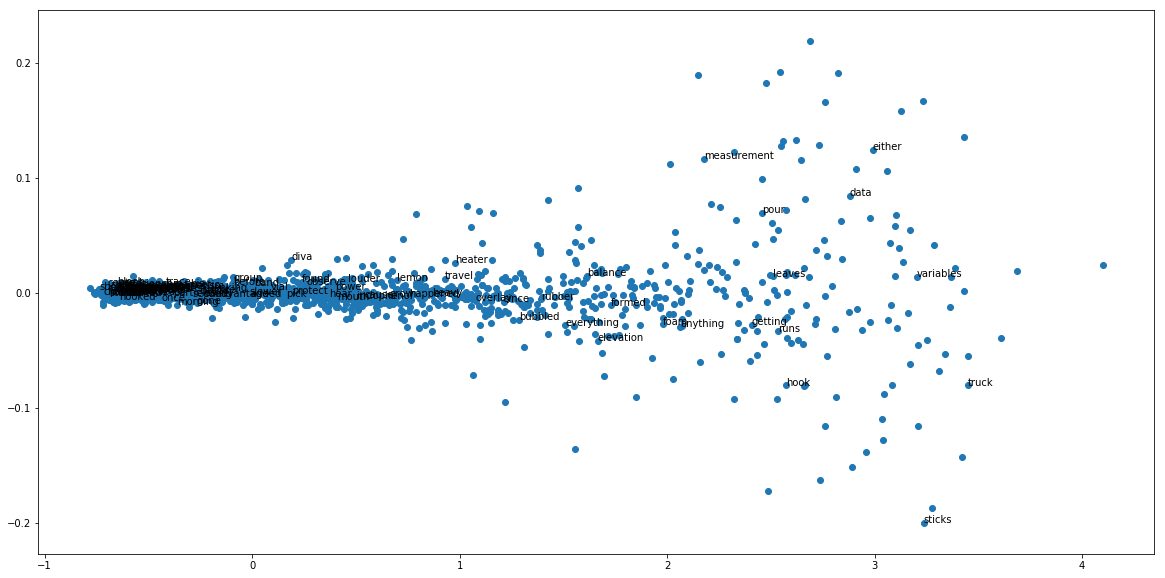

In [120]:
# fitting a 2d PCA model to the vectors for visualization
X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
plt.figure(figsize=(20,10))
plt.scatter(result[:, 0], result[:, 1])
words = list(model.wv.index2entity[500:600])
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))


plt.show()

In [108]:
def get_sec2vec(model,words):
    word_array = np.vstack([model[word] if word in model.wv.vocab else np.zeros(model.vector_size,) for word in words])
    return np.mean(word_array,axis=0)

def merge_sec2vec(model,sentence_list):
    return np.vstack([get_sec2vec(model,sec) for sec in sentence_list ])

In [109]:
CS_df=get_DataFrame()
CS_df=get_words(CS_df,isStopWord=False)

In [113]:
que_vec = merge_sec2vec(model,(CS_df['Question_words']))
ref_vec = merge_sec2vec(model,(CS_df['ReferenceAnswer_words']))
student_vec = merge_sec2vec(model,(CS_df['StudentAnswer_words']))

In [115]:
CS_dict={'CS_que_ref':[],
         'CS_que_stu':[],
         'CS_ref_stu':[]}

for i in range(len(que_vec)):
    CS_dict['CS_que_ref']=CS_dict.get('CS_que_ref',[])+[cosine(que_vec[i,:], ref_vec[i,:])]
    CS_dict['CS_que_stu']=CS_dict.get('CS_que_stu',[])+[cosine(que_vec[i,:], student_vec[i,:])]
    CS_dict['CS_ref_stu']=CS_dict.get('CS_ref_stu',[])+[cosine(ref_vec[i,:], student_vec[i,:])]

In [116]:
X_CS=pd.DataFrame.from_dict(CS_dict)
y=CS_df['Accuracy']

In [117]:
models = get_model()
names,results = get_baseline_performance(X_CS, y, models)  

LR: 0.5959 (0.0643)
KNN: 0.549 (0.02211)
NB-Bernoulli: 0.5959 (0.0643)
SGD: 0.5435 (0.1069)
SVM: 0.5959 (0.0643)
GBC: 0.5673 (0.03586)
RF: 0.5643 (0.03913)
MLP: 0.5959 (0.0643)


The performance for cosine similarity is worst than what we got for BoWs. Averaging all word vectors from a document might be the cause of this. Usually cosine similarity produce better results and is preffered over jaccard similarity.
Things that might help: 
- instead of averaging, trying Smooth Inverse Frequency (SIF)
- taking SIF using word vector per sentence instead of per document
- trying out doc2vec approach with larger dataset